# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning!

```
All code and text is handwritten by myself, as part of coding along to Daniel Bourke's series

https://github.com/mrdbourke
```

Previously, we leveraged *feature extraction* transfer learning to get better results than our own model got, with only 10% of the original data used. 

In this section we learn about another type of transfer learning, *fine-tuning*!

For this type of transfer learning we unfreeze the pre-trained model weights that are imported and tweak them to better suit our own data.

In *feature extraction transfer learning* generally only the top 1-3 layers of the pre-trained model are trained on our own data, but in *fine-tuning transfer learning* anywhere from 1 to all of the layers of the pre-trained model could be trained. 

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*

## Specifics in this Notebook
* Introduction to fine-tuning
* Use the Keras Functional API
* Continue to use the smaller dataset
* Data augmentation to boost our training
* Running a series of experiments on the Food Vision Data
  - Model 0: transfer learning model using the Keras Functional API
  - Model 1: 
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
* Introduction to ModelCheckpoint callback to save intermediate results from longer training sessions
* Comparing results with TensorBoard



In [4]:
# Confirm we are running on a GPU for faster results
!nvidia-smi

Fri Jul  1 19:35:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |    266MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Creating helper functions

Helper functions are blocks of code that generally will be used frequently between projects. 
* e.g. a plotting function for a model's `history` object (in our case the `plot_loss_curves()` function).
* A good way to access these functions is through storing them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And them import the needed functionality.

In [5]:
# Get helper_functions.py from the course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import the helper functions that are needed for this module
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-07-01 19:35:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-01 19:35:56 (88.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Using 10 Food classes

We will continue to use smaller data sets than in the first 3 modules

We will use the pretrained models within tf.keras.applications and also how to fine-tune them to our custom dataset.

We will use a new dataloader function `image_dataset_from_directory`.

We will be using the Keras Functional API to build our models. It's more flexible than using the tf.keras.Sequential() API that we used in the previous 4 modules.

In [6]:
# Get 10% of the 10 class data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-07-01 19:35:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   251MB/s    in 0.6s    

2022-07-01 19:35:58 (251 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
# Walk through the directories
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tr

In [8]:
# Define training and test filpaths
# Create  training and test directories
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

We are switching to `image_data_from_directory` instead of `ImageDataGenerator`'s `flow_from_directory`. However it works in a similar manner and needs the same folder structure

One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator. The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.


In [9]:
# Creat data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=32)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

For the above:
- `(None, 224, 224, 3)` is the tensor shape of our images. `None=batch size`, `224=height and width`, `3=color channel`
- `(None, 10)` refers to the tensor shape of the labels where `None=batch size`, and `10=number of possible labels`

`batch_size` is `None` because this is oinly used during model training. Currently it is acting like a placeholder.

In [11]:
# Class names of the dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See example of batch of data using `take()` method
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.46025818e+02 7.74221954e+01 7.04712982e+01]
   [1.51669968e+02 9.34068909e+01 8.63086777e+01]
   [1.54709183e+02 1.08565369e+02 1.04132973e+02]
   ...
   [1.40536743e+02 1.20269447e+02 9.90013428e+01]
   [1.29961945e+02 1.05208420e+02 8.81962738e+01]
   [1.20489418e+02 9.42030334e+01 7.10898132e+01]]

  [[1.57517853e+02 1.43787628e+02 1.29133926e+02]
   [1.56303894e+02 1.46519135e+02 1.33407516e+02]
   [1.51370529e+02 1.46835464e+02 1.36702484e+02]
   ...
   [1.42908157e+02 1.22305122e+02 1.02717812e+02]
   [1.29376450e+02 9.51865997e+01 7.34620285e+01]
   [1.25383781e+02 7.03207550e+01 3.41684837e+01]]

  [[1.59473846e+02 1.43294647e+02 1.32901779e+02]
   [1.59554535e+02 1.41483093e+02 1.34894775e+02]
   [1.59561234e+02 1.39178574e+02 1.36203751e+02]
   ...
   [1.43105545e+02 1.17196182e+02 9.61216507e+01]
   [1.06141640e+02 7.34185638e+01 5.21700935e+01]
   [1.19513474e+02 5.99322357e+01 2.17531719e+01]]

  ...

  [[1.50729156e+02 2.37782860e+01 3.06308861e+01]
   [1

### Model 0: Building a transfer learning model using the Keras API

We are going to use `tf.keras.applications` module. It contains a series of already trained computer vision models (trained on ImageNet). We will use this with the Keras API. 

The steps for model 0:
1. Create a pre-trained base model object from a target model pulled from `tf.keras.applications`. For this model we will set `include_top` parameter to `False` as we are going to create our own top, aka output layer. 
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights of the pre-trained model. 
3. Define the input layer for our model. i.e. what data shape are we inputting?
4. [Optional] Normalize our data (note: not all models that can be accessed from `tf.keras.applications` need this.)
5. Pass the inputs to the model
6. Pool the outputs of the base model into a shape that works with out output activation layer
7. Create the output activation layer using `tf.keras.layers.Dense()`
8. Combine the input and output layers into one model using `tf.keras.Model()`
9. Compile
10. Fit with callbacks

In [13]:
# 1. Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# 4. Normalize (commented our for EfficientNet because does not need. Use for ResNet as it will speed up convergence)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model 
x = base_model(inputs)
# Check the shape
print(f'Shape after base_model: {x.shape}')

# 6. Average pool the outputs of the base model (this aggregates the major information captured in the network and reduces the computational complexity)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after pooling: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs and outputs 
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model! 
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)), # we are reducing the amount of validation data per step to speed up the runtime.
                                 callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_feature_extract')])

16719872/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
Shape after pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220701-193603
Epoch 1/5
24/24 [==============================] - 23s 259ms/step - loss: 1.9196 - accuracy: 0.4000 - val_loss: 1.3532 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - 4s 155ms/step - loss: 1.1513 - accuracy: 0.7440 - val_loss: 0.9493 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 4s 153ms/step - loss: 0.8628 - accuracy: 0.7920 - val_loss: 0.7569 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 5s 186ms/step - loss: 0.7001 - accuracy: 0.8333 - val_loss: 0.6432 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 5s 185ms/step - loss: 0.5968 - accuracy: 0.8600 - val_loss: 0.6104 - val_accuracy: 0.8355


Pretty good performance for such a plug and play solution.

Above we implemented **feature extraction transfer learning** again, like in the last module. i.e. we passed our own data into an already pre-trained model and asked it to discern patterns from the existing weights and biases. We put our own output layer on top to ensure that the outputs matched our desired number of classes

*Note*: we used the Keras Functional API here instead of Sequential API. This API is better than Sequential for more complex models and is good practice.

In [14]:
# View the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

Jesus, that's a lot of layers. I did not expect that. Nor do I understand all the layers. 

In [15]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

Interesting how the layers' features increase and then decrease (oscillate). Since we are using a pre-trained model it can help to imagine these parameters as patterns that the base model has learned on another dataset. Remember, they are not being updated on our data because we set `base_model.trainable = False`.

In [16]:
# Overall model summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


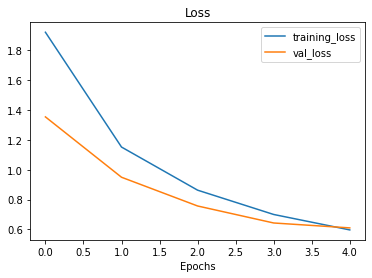

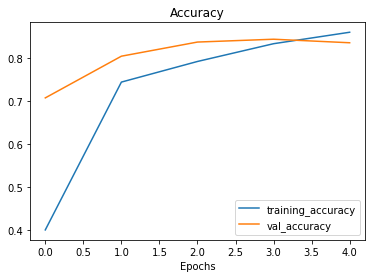

In [17]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

First, let's look at `tf.keras.layers.GlobalAveragePooling2D()`. This transforms a 4D tensor into a 2D tensor by averaging values across the inner axes. 

In the below example we see the input tensor of shape (1, 4, 4, 3) get reduced to shape (1, 3).

In [18]:
# Define input ensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4 ,4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n{input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shapes of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


Another approach to implement `tf.keras.layers.GlobalAveragePooling2D()` is to use `tf.reduce_mean`.

In [19]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1,2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

This makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`). Additionally, it condenses the information found by the base model into a lower dimension feature vector.

**Note**: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the

## Running a series of transfer learning experiments

Above and in the last module we ran using 10% of the training data, but what happens if we use only 1%? *What kind of results would be expected when using 99% less data than the original CNN models we built?*

We will run the following to find out
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

* Although we use different training sets we will always use the same test set
* All experiments will be done with `EfficientNetB0` model within the `tf.keras.applications` module.
* We will track using the `create_tensorboard_callback()` function we creates.

In [20]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

--2022-07-01 19:36:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  68.0MB/s    in 1.9s    

2022-07-01 19:36:49 (68.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
# Walk through the data / dirs to understand
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

WOW! only **7** images of each class

In [22]:
# Load in the data
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

We will do this by using `tf.keras.layers.experimental.preprocessing` and creating a dedicated data augmentation layer. 

This is a very powerful function within TensorFlow nad adding this data augmentation layer has some benefits.
* Preprocessing of the images happens on the GPU rather than the CPU.
 * Image preprocessing is best on GPU while text and structured data is better on the CPU
* Image data augmentation only happens during training so you can still export the model and use it elsewhere. Allows for other people to more easily replicate the model.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

*Note*: We are using `tf.keras.experimental` which contains `preprocessing`. This means that although the code is stable it may change slightly down the road or be relocated within the keras modules.

The **data augmentation transformations** that we are going to use are:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - flips image on horizontal or vertical axis.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - randomly rotates image by a specified amount.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - randomly zooms into an image by specified amount.
* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - randomly shifts image height by a specified amount.
* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - randomly shifts image width by a specified amount.
* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

"""
I am not sure why we imported in this descending order. 
Also we reimported tf even though we have it when creating the dirs above?
"""

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.5),
  preprocessing.RandomZoom(0.5),
  preprocessing.RandomHeight(0.5),
  preprocessing.RandomWidth(0.5),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

The above data augmentation Sequential model can be plugged in as a layer to our transfer learning model later.

Let's test it first though and get some visualization of its effects.

(1, 512, 512, 3)


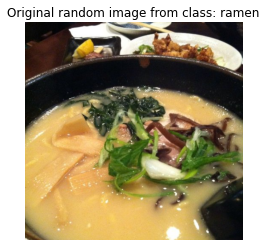

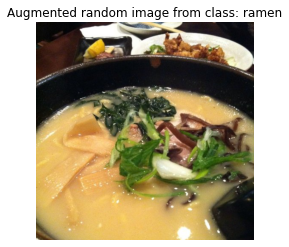

In [37]:
# # Generate a random image to view
# import os
# import random
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# target_class = random.choice(train_data_1_percent.class_names) # pick a random class
# target_dir = '10_food_classes_1_percent/train/' + target_class # create the target directory
# random_image = random.choice(os.listdir(target_dir)) # choose a random image from the target directory
# random_image_path = target_dir + '/' + random_image # create the chosen random image's path
# img = mpimg.imread(random_image_path) # read in the chosen target image
# plt.imshow(img)
# plt.title(f'Original random image from class: {target_class}')
# plt.axis(False);

# # Augment the image
# augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
# plt.figure()
# plt.imshow(tf.squeeze(augmented_img)/255.) # normalization after augmentation
# plt.title(f'Augmented random image from class: {target_class}')
# plt.axis(False);

# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
print(augmented_img.shape)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Hmmm.... I am not sure as to why the image is not augmenting. I attempted to run in the original notebook and appears to not be augmenting either. I took code from other keras guides and read their documentation but cannot figure out why it is not augmenting.

I am going to continue anyways...

## Model 1: Feature extraction transfer learning only 1% of the data with data augmentation.

In [40]:
# Setup input shape and base model, freeze the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
input = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220701-202302
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3814 - accuracy: 0.1571 - val_loss: 2.2063 - val_accuracy: 0.1990
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1528 - accuracy: 0.2571 - val_loss: 2.0951 - val_accuracy: 0.2747
Epoch 3/5
3/3 [==============================] - 2s 974ms/step - loss: 1.9628 - accuracy: 0.4000 - val_loss: 1.9772 - val_accuracy: 0.3750
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7726 - accuracy: 0.5571 - val_loss: 1.8627 - val_accuracy: 0.4408
Epoch 5/5
3/3 [==============================] - 2s 1s/step - loss: 1.5878 - accuracy: 0.6429 - val_loss: 1.7862 - val_accuracy: 0.4605


Wow, pretty good for using only 7 images to train on!! (Even with the questionable data augmentation too). 

In [41]:
# model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

We can see from the summary output that the data augmentation is built into the model. With this we can save and then reload the model elsewhere *with the augmentation layers*.

Remember: **This data augmentation runs during training**. This means that if we use our model for inference (predicting the class of an image) the data augmentation will be automatically turned off. 

Let's take a look at this...

In [43]:
# Evaluate on the test set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 81ms/step - loss: 1.7738 - accuracy: 0.4956


[1.7737640142440796, 0.49559998512268066]

The results above vary from our model output because we only used 25% of our test data for valudating before. 

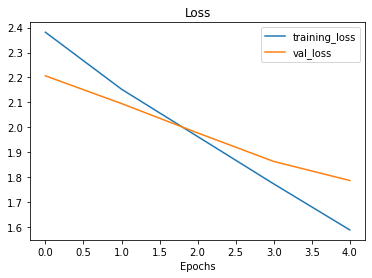

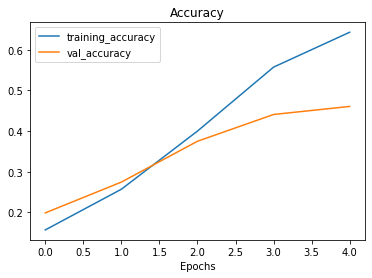

In [44]:
# How do our loss curves look?
plot_loss_curves(history_1_percent)

It looks like the metrics on both datasets would improve if we kept training for more epochs. But for now, we've got more experiments to do and we will move on.

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Let's now compare how learning with 10% of the data does compared to the 1% used above.

Note: In real life there isn't a clear cut approach for what experiments to run. It takes practice and intuition to build optimized training experiments. 

In [45]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2022-07-01 20:43:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.250.4.128, 216.58.203.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   301MB/s    in 0.5s    

2022-07-01 20:43:25 (301 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [46]:
# Setup data input
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

# Note: the test data is the same as the previous experiment, we could
# skip creating this, but this is a code-along and we should practice!
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Confirmed dataset size -- 75 instead of 7 per class

In [47]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2),
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create the frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
input = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.001),
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Createing a ModelCheckpoint callback (NEW TYPE OF CALLBACK!)